# Sistemas Inteligentes: Aprendizaje Automático

_Guillermo Facundo Colunga_

## Introducción

Para la práctica de aprendizaje automático se empleará el paquete caret de R para evaluar el mejor modelo que sea capaz de predecir el tipo de cáncer según la información de expresión de losgenes en distintas muestras de pacientes reales.

Para ello se evaluarán distintos paradigmas de clasificación: **árbol de decisión, vecinos más cercanos, redes neuronales y máquinas de vector soporte**. Y a continuación se evaluarán de forma individual y colectiva.


Para empezar a trabajar con el paquete `caret` debemos de cargarlo en R. También cargaremos el paquete `mlbench`

In [1]:
library(caret)
library(mlbench)
library(ggplot2)

Loading required package: lattice
Loading required package: ggplot2


## Carga de datos en R

Lo primero que debemos hacer es cargar los datos de las muestras en R. Para ello previamente hemos descargado y descomprimido los [datos](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq) en el directorio `data`.

In [2]:
geneLevel <- read.csv('./data/data.csv',stringsAsFactors = F)
label <- read.csv('./data/labels.csv',stringsAsFactors = F)
tcga <- merge(geneLevel, label, sort = F)
tcga$X <- NULL

Los datos cargados contienen 20531 variables y 801 instancias. Nuestro ordenador no puede trabar con tantos datos así que emplearemos los números de nuestro identificador universitario para escoger 100 variables.

In [3]:
set.seed(236856) #Pon aquí los número de tu UO
tcga.filtered <- tcga[,c(sample(ncol(tcga)-1,100),ncol(tcga))]

A continuación seleccionamos el porcentaje de datos para entrenamiento y para la evaluación posterior.

In [4]:
inTrain <- createDataPartition(
## indicamos la clase
y = tcga.filtered$Class,
## el porcentaje de instancias para entrenamiento
p = .75,
## controla el formato de salida
list = FALSE
)

training <- tcga.filtered[ inTrain,]
testing <- tcga.filtered[-inTrain,]

# Usaremos el método cross-validation ya que es el que mayor precisión nos da.
ctrl <- trainControl(method="cv",  number=10)

## Árbol de decisión

De acuerdo con wikipedia, un árbol de decisión es un mecanismo en el que dado un conjunto de datos se fabrican diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema.

### Modelo J48

In [5]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con J48.
j48Fit <- train(
    Class ~ .,
    data = training,
    method = "J48",
    trControl = ctrl
)

In [6]:
confusionMatrix(predict(j48Fit,testing), factor(testing$Class))$overall[1:4]

Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9045226     0.8739835     0.8549181     0.9415330

### Modelo rpart

In [7]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart.
rpartFit <- train(
  Class ~ .,
  data = training,
  method = "rpart",
  trControl = ctrl,
  tuneLength = 6
)

rpartFit$results[rownames(rpartFit$bestTune),1:3]

cp,Accuracy,Kappa
0.00795756,0.8603015,0.8143999


In [8]:
confusionMatrix(predict(rpartFit,testing), factor(testing$Class))$overall[1:4]

Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8542714     0.8069964     0.7974599     0.9001806

### Modelo rpart2

In [9]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
rpart2Fit <- train(
  Class ~ .,
  data = training,
  method = "rpart2",
  trControl = ctrl,
  tuneLength = 6
) 

rpart2Fit$results[rownames(rpart2Fit$bestTune),1:3]

,maxdepth,Accuracy,Kappa
5,8,0.8619992,0.8164838


In [10]:
confusionMatrix(predict(rpart2Fit,testing), factor(testing$Class))$overall[1:4]

Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8542714     0.8069964     0.7974599     0.9001806

## Vecinos más cercanos

In [11]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
knnFitTraining <- train(
  Class ~ .,
  data = training,
  method = "knn",
  trControl = ctrl,
  tuneLength = 6
)
knnFitTraining$results[rownames(knnFitTraining$bestTune),1:3]

k,Accuracy,Kappa
5,0.9652056,0.9537264


In [12]:
confusionMatrix(predict(knnFitTraining,testing), factor(testing$Class))$overall[1:4]

Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9698492     0.9602503     0.9355328     0.9888564

## Redes neuronales

In [15]:
ctrl <- trainControl( 
    method = "boot632", 
    number = 10
)

# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit <- train(
    Class ~ .,
    data = training,
    method = "mlp",
    trControl = ctrl,
    tuneGrid = data.frame(size=seq(19,25,2))
)

# Mostramos el resultado obtenido tras realizar el entrenamiento.
nn1LFit

Multi-Layer Perceptron 

602 samples
100 predictors
  5 classes: 'BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD' 

No pre-processing
Resampling: Bootstrapped (10 reps) 
Summary of sample sizes: 602, 602, 602, 602, 602, 602, ... 
Resampling results across tuning parameters:

  size  Accuracy   Kappa
  19    0.3588939  0    
  21    0.3327008  0    
  23    0.3555623  0    
  25    0.3306315  0    

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was size = 19.

In [16]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn2LFit <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrl,
    tuneGrid = expand.grid(layer1=seq(9,13,2),layer2=seq(9,13,2),layer3=0)
)

# Mostramos el resultado obtenido tras realizar el entrenamiento.
nn2LFit

Warning message:
“At least one layer had zero units and were removed. The new structure is 9->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->9”Warning message:
“At least o

“At least one layer had zero units and were removed. The new structure is 9->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->11”Warning message:
“At least one layer had zer

Multi-Layer Perceptron, with multiple layers 

602 samples
100 predictors
  5 classes: 'BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD' 

No pre-processing
Resampling: Bootstrapped (10 reps) 
Summary of sample sizes: 602, 602, 602, 602, 602, 602, ... 
Resampling results across tuning parameters:

  layer1  layer2  Accuracy   Kappa
   9       9      0.3719919  0    
   9      11      0.3719919  0    
   9      13      0.3719919  0    
  11       9      0.3719919  0    
  11      11      0.3719919  0    
  11      13      0.3719919  0    
  13       9      0.3719919  0    
  13      11      0.3719919  0    
  13      13      0.3719919  0    

Tuning parameter 'layer3' was held constant at a value of 0
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were layer1 = 9, layer2 = 9 and layer3 = 0.

In [18]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn3LFit <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrl,
    tuneGrid = expand.grid(layer1=seq(9,11,2),layer2=seq(9,11,2),layer3=seq(9,11,2))
)

# Mostramos el resultado obtenido tras realizar el entrenamiento.
nn3LFit

Multi-Layer Perceptron, with multiple layers 

602 samples
100 predictors
  5 classes: 'BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD' 

No pre-processing
Resampling: Bootstrapped (10 reps) 
Summary of sample sizes: 602, 602, 602, 602, 602, 602, ... 
Resampling results across tuning parameters:

  layer1  layer2  layer3  Accuracy   Kappa
   9       9       9      0.3719919  0    
   9       9      11      0.3719919  0    
   9      11       9      0.3719919  0    
   9      11      11      0.3719919  0    
  11       9       9      0.3719919  0    
  11       9      11      0.3719919  0    
  11      11       9      0.3719919  0    
  11      11      11      0.3719919  0    

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were layer1 = 9, layer2 = 9 and layer3 = 9.

In [19]:
nn2LFit$results[,1:4]

,layer1,layer2,layer3,Accuracy
9,9,9,0,0.3719919
7,9,11,0,0.3719919
8,9,13,0,0.3719919
3,11,9,0,0.3719919
1,11,11,0,0.3719919
2,11,13,0,0.3719919
6,13,9,0,0.3719919
4,13,11,0,0.3719919
5,13,13,0,0.3719919


In [20]:
nn3LFit$results[,1:4]

,layer1,layer2,layer3,Accuracy
8,9,9,9,0.3719919
7,9,9,11,0.3719919
6,9,11,9,0.3719919
5,9,11,11,0.3719919
4,11,9,9,0.3719919
3,11,9,11,0.3719919
2,11,11,9,0.3719919
1,11,11,11,0.3719919


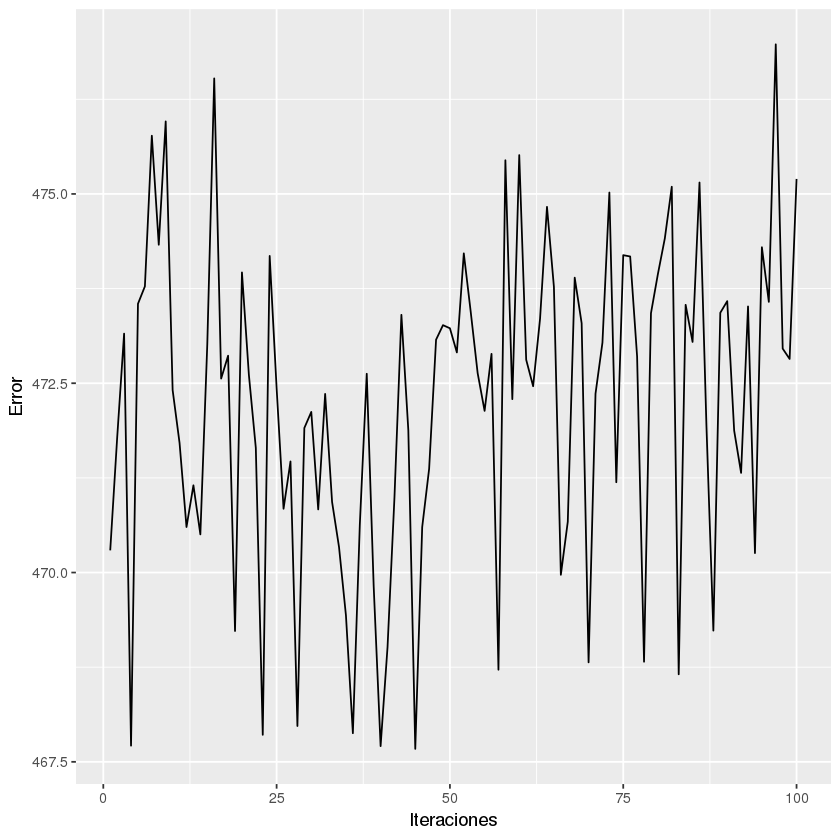

In [21]:
ggplot() + geom_line(aes(x=1:length(nn1LFit$finalModel$IterativeFitError), y=nn1LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error")

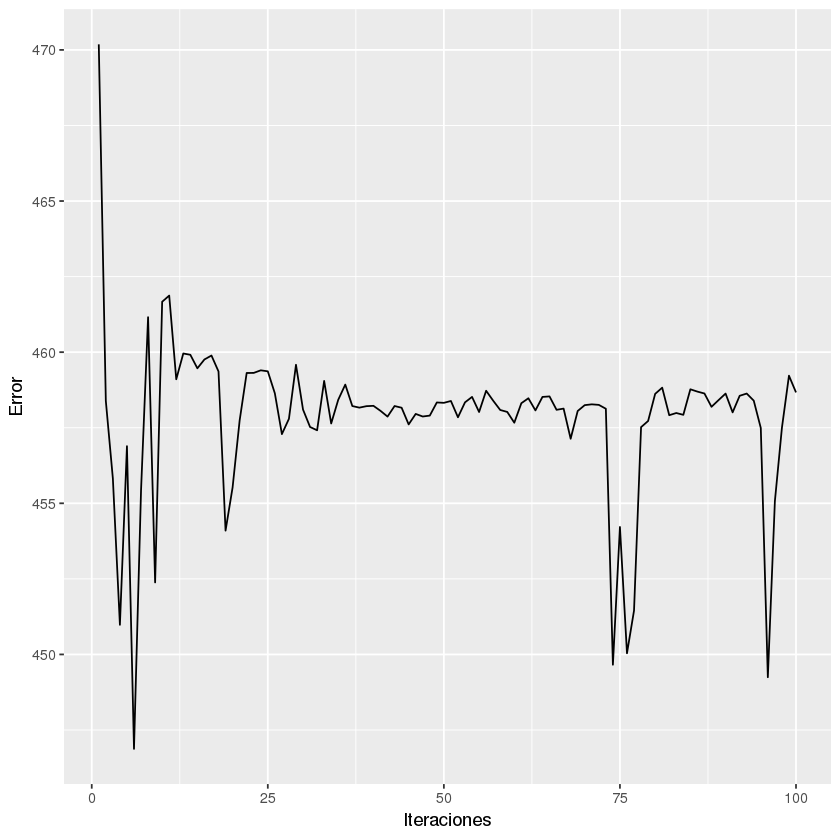

In [22]:
ggplot() + geom_line(aes(x=1:length(nn2LFit$finalModel$IterativeFitError), y=nn2LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error")

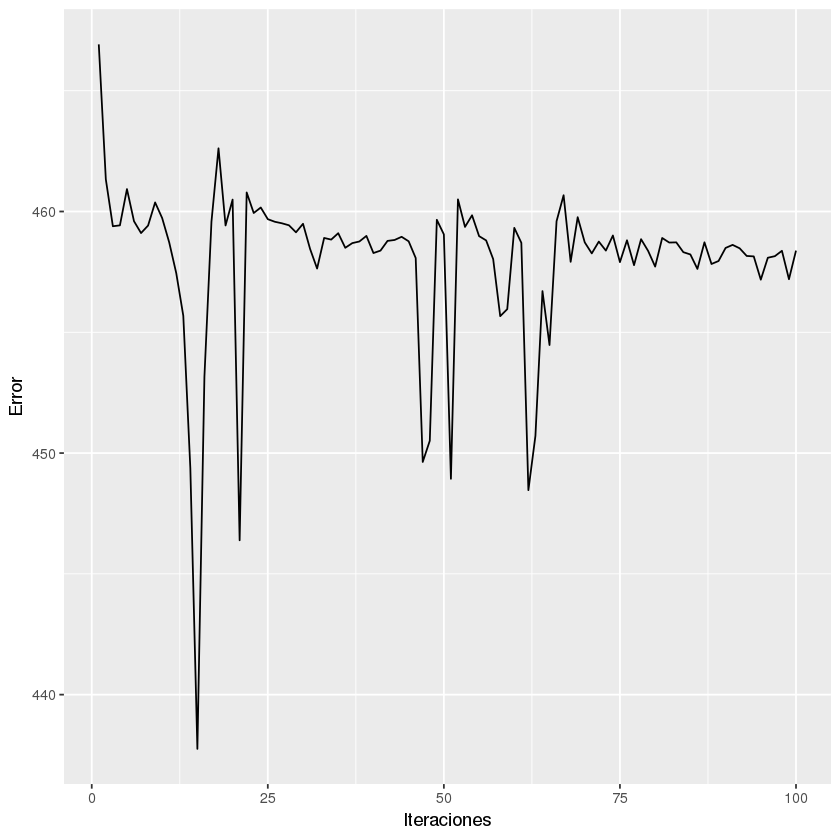

In [23]:
ggplot() + geom_line(aes(x=1:length(nn3LFit$finalModel$IterativeFitError), y=nn3LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error")